In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import itertools
from keras.callbacks import History, EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Input, GRU, Embedding, LSTM, Dropout

Using TensorFlow backend.


In [2]:
fuzzy = pd.read_csv("C:/Users/pio-f/Desktop/Fuzzy2_dataset.csv", converters={"DATA0":lambda x: int(x, 16),"DATA1":lambda x: int(x, 16),"DATA2":lambda x: int(x, 16),"DATA3":lambda x: int(x, 16),"DATA4":lambda x: int(x, 16),"DATA5":lambda x: int(x, 16),"DATA6":lambda x: int(x, 16),"DATA7":lambda x: int(x, 16)})
fuzzy.head()

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478196e+09,0545,8,216,0,0,138,0,0,0,0,R
1,1.478196e+09,0002,8,0,0,0,0,0,1,7,21,R
2,1.478196e+09,0153,8,0,33,16,255,0,255,0,0,R
3,1.478196e+09,0130,8,25,128,0,255,254,127,7,96,R
4,1.478196e+09,0131,8,23,128,0,0,101,127,7,159,R


In [3]:
fuzzy['Timestamp'] = pd.to_datetime(fuzzy['Timestamp'], origin=pd.Timestamp('2020-01-01'))
fuzzy.sort_values(by = ["Timestamp","CAN ID"], inplace = True)
fuzzy.head()

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
15533,2020-01-01 00:00:01.478195712,0000,8,219,128,220,27,141,193,95,50,T
37822,2020-01-01 00:00:01.478195712,0000,8,95,237,27,121,90,194,232,137,T
74417,2020-01-01 00:00:01.478195712,0000,8,193,22,103,217,138,195,153,172,T
81264,2020-01-01 00:00:01.478195712,0000,8,181,120,186,73,120,239,121,218,T
88344,2020-01-01 00:00:01.478195712,0000,8,70,194,36,16,81,129,95,217,T


In [4]:
fuzzy.set_index('Timestamp').head()

,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
Timestamp,,,,,,,,,,,
2020-01-01 00:00:01.478195712,0000,8,219,128,220,27,141,193,95,50,T
2020-01-01 00:00:01.478195712,0000,8,95,237,27,121,90,194,232,137,T
2020-01-01 00:00:01.478195712,0000,8,193,22,103,217,138,195,153,172,T
2020-01-01 00:00:01.478195712,0000,8,181,120,186,73,120,239,121,218,T
2020-01-01 00:00:01.478195712,0000,8,70,194,36,16,81,129,95,217,T


In [5]:
fuzzyT = fuzzy[fuzzy["Flag"] == "T"]
fuzzyR = fuzzy[fuzzy["Flag"] == "R"]

In [6]:
fuzzyT

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
15533,2020-01-01 00:00:01.478195712,0000,8,219,128,220,27,141,193,95,50,T
37822,2020-01-01 00:00:01.478195712,0000,8,95,237,27,121,90,194,232,137,T
74417,2020-01-01 00:00:01.478195712,0000,8,193,22,103,217,138,195,153,172,T
81264,2020-01-01 00:00:01.478195712,0000,8,181,120,186,73,120,239,121,218,T
88344,2020-01-01 00:00:01.478195712,0000,8,70,194,36,16,81,129,95,217,T
...,...,...,...,...,...,...,...,...,...,...,...,...
2811433,2020-01-01 00:00:01.478198272,07ff,8,203,13,215,27,141,111,110,145,T
2818909,2020-01-01 00:00:01.478198272,07ff,8,103,225,46,52,240,157,130,179,T
2833042,2020-01-01 00:00:01.478198272,07ff,8,75,181,212,1,166,55,133,94,T
2837508,2020-01-01 00:00:01.478198272,07ff,8,64,15,237,143,67,207,120,62,T


In [7]:
frames = [fuzzyT,fuzzyR]
dataset = pd.concat(frames)
dataset

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
15533,2020-01-01 00:00:01.478195712,0000,8,219,128,220,27,141,193,95,50,T
37822,2020-01-01 00:00:01.478195712,0000,8,95,237,27,121,90,194,232,137,T
74417,2020-01-01 00:00:01.478195712,0000,8,193,22,103,217,138,195,153,172,T
81264,2020-01-01 00:00:01.478195712,0000,8,181,120,186,73,120,239,121,218,T
88344,2020-01-01 00:00:01.478195712,0000,8,70,194,36,16,81,129,95,217,T
...,...,...,...,...,...,...,...,...,...,...,...,...
3750213,2020-01-01 00:00:01.478201088,0690,8,0,0,0,0,160,34,0,0,R
3750396,2020-01-01 00:00:01.478201088,0690,8,0,0,0,0,160,34,0,0,R
3750579,2020-01-01 00:00:01.478201088,0690,8,0,0,0,0,160,34,0,0,R
3750762,2020-01-01 00:00:01.478201088,0690,8,0,0,0,0,160,34,0,0,R


In [8]:
dataset['Flag'].unique()

array(['T', 'R'], dtype=object)

In [9]:
X_input = dataset[['DATA0','DATA1','DATA2','DATA3','DATA4','DATA5','DATA6','DATA7']].values
y_target = dataset['Flag'].values

In [10]:
def temporalize(X,y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback):
        t = []
        for j in range(0, lookback):
            t.append(X[[i+j], :])
        output_X.append(t)
        output_y.append(y[i+lookback])
    return output_X,output_y

In [11]:
le = LabelEncoder()
y_target = le.fit_transform(y_target)

In [28]:
X_in, y_t = temporalize(X = X_input, y=y_target, lookback=10)

In [32]:
X_in = np.array(X_in)

In [33]:
X_in = X_in.reshape(X_in.shape[0],10,8)

In [34]:
X_in.shape

(3751014, 10, 8)

In [30]:
y_t = np.array(y_t)

In [31]:
y_t = to_categorical(y_t, 2)
y_t[0]
y_t.shape

(3751014, 2)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_in, y_t, test_size=0.3)

In [36]:
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(10,8)))
model.add(Dropout(0.2))
model.add(LSTM(40, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(40, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu'))
model.add(Dense(2, activation="softmax" ))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 10, 20)            2320      
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 20)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 10, 40)            9760      
_________________________________________________________________
dropout_10 (Dropout)         (None, 10, 40)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 10, 60)            24240     
_________________________________________________________________
dropout_11 (Dropout)         (None, 10, 60)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 40)                16160     
__________

In [37]:
model.compile(optimizer='rmsprop' , loss= 'mean_squared_error', metrics=['accuracy'])

In [38]:
history = History()

In [39]:
model.fit(X_train, y_train, epochs=5, batch_size = 1000, validation_split=0.1, callbacks=[history])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 2363138 samples, validate on 262571 samples
Epoch 1/5





2363138/2363138 [==============================] - 244s 103us/step - loss: 0.0010 - acc: 0.9989 - val_loss: 2.4506e-08 - val_acc: 1.0000
Epoch 2/5
2363138/2363138 [==============================] - 283s 120us/step - loss: 1.1504e-05 - acc: 1.0000 - val_loss: 7.4038e-13 - val_acc: 1.0000
Epoch 3/5
2363138/2363138 [==============================] - 281s 119us/step - loss: 7.7169e-06 - acc: 1.0000 - val_loss: 1.1424e-12 - val_acc: 1.0000
Epoch 4/5
2363138/2363138 [==============================] - 279s 118us/step - loss: 3.4000e-06 - acc: 1.0000 - val_loss: 1.3302e-12 - val_acc: 1.0000
Epoch 5/5
2363138/2363138 [==============================] - 280s 118us/step - loss: 5.1536e-06 - acc: 1.0000 - val_loss: 2.5020e-11 - val_acc: 1.0000


In [40]:
model.evaluate(X_test, y_test)

1125305/1125305 [==============================] - 129s 115us/step


[1.372236361875272e-06, 0.9999982227040669]

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [42]:
y_pred = model.predict_classes(X_test, batch_size=1000, verbose = 0)

In [43]:
y_labels = np.argmax(y_test, axis=1)

In [44]:
cm = confusion_matrix(y_labels, y_pred)

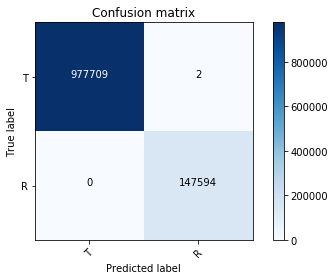

In [45]:
plot_confusion_matrix(cm, ['T','R'])

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


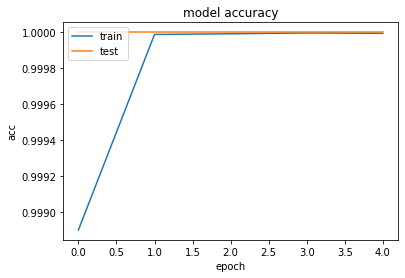

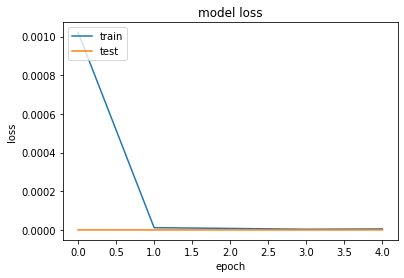

In [46]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()